# 9.8.3 Marketing Board Model

<font size="3">二つの競争的な企業が、長期的に利潤を最大化する。
<font size="3">それぞれの企業は期首に$s_1$,$s_2$だけ製品を持っていて、当期にその中から$q_1$,$q_2$だけ輸出し、$x_1$,$x_2$を保存する。
<font size="3">市場価格はお互いの輸出量によって決まり、来期のsは$s_{t+1} = x_t + \epsilon_{t+1}$で与えられる。

<font size="3">制約条件

<font size="3">$s_1\in[0, ∞)$,  $s_2\in[0, ∞)$

<font size="3">$x_p\in[0, s_p)$

In [1]:
using QuantEcon
using Optim
using BasisMatrices
using Plots

In [2]:
type MarketingBoardModel
    kappa::Float64　#費用定数
    sigma::Float64 #生産ショックにかかる定数
    delta::Float64 #割引定数
    gamma::Float64 #状態遷移関数の係数
    x_max::Float64 #最大保存量
    snodes::Array{Float64}
end

In [3]:
kappa = 0.05 
gamma = -0.5
mu = log([0.5; 0.5])
sigma = 0.2
delta = 0.95
x_max = 0.2

0.2

In [4]:
nshocks = [3; 3]
cov = (sigma^2)*eye(2)
epsilon, weight = qnwlogn(nshocks, mu, cov)

(
[0.353611 0.353611; 0.5 0.353611; … ; 0.5 0.706991; 0.706991 0.706991],

[0.0277778,0.111111,0.0277778,0.111111,0.444444,0.111111,0.0277778,0.111111,0.0277778])

In [5]:
n = [20; 20]
s_min = minimum(epsilon)

0.35361117610946247

In [6]:
s_max = maximum(epsilon) + x_max

0.9069912290402582

In [7]:
sgrid0 = linspace(s_min, s_max, n[1])
basis =  Basis(SplineParams(sgrid0, 0, 3), SplineParams(sgrid0, 0, 3))
snodes, (s1_vec, s2_vec) = nodes(basis)

(
[0.353611 0.353611; 0.36332 0.353611; … ; 0.897283 0.906991; 0.906991 0.906991],

([0.353611,0.36332,0.382736,0.411862,0.440987,0.470112,0.499238,0.528363,0.557488,0.586613  …  0.673989,0.703114,0.73224,0.761365,0.79049,0.819615,0.848741,0.877866,0.897283,0.906991],[0.353611,0.36332,0.382736,0.411862,0.440987,0.470112,0.499238,0.528363,0.557488,0.586613  …  0.673989,0.703114,0.73224,0.761365,0.79049,0.819615,0.848741,0.877866,0.897283,0.906991]))

In [8]:
Φ = BasisMatrix(basis, Expanded(), snodes, 0)
initial_c = Φ.vals[1] \ ones(size(Φ.vals[1])[1], 2)

484×2 Array{Float64,2}:
 1.0  1.0
 1.0  1.0
 1.0  1.0
 1.0  1.0
 1.0  1.0
 1.0  1.0
 1.0  1.0
 1.0  1.0
 1.0  1.0
 1.0  1.0
 1.0  1.0
 1.0  1.0
 1.0  1.0
 ⋮       
 1.0  1.0
 1.0  1.0
 1.0  1.0
 1.0  1.0
 1.0  1.0
 1.0  1.0
 1.0  1.0
 1.0  1.0
 1.0  1.0
 1.0  1.0
 1.0  1.0
 1.0  1.0

In [9]:
MBM = MarketingBoardModel(kappa, sigma, delta, gamma, x_max, snodes)

MarketingBoardModel(0.05,0.2,0.95,-0.5,0.2,[0.353611 0.353611; 0.36332 0.353611; … ; 0.897283 0.906991; 0.906991 0.906991])

In [10]:
box11 = ones(size(epsilon, 1))
box22 = ones(size(epsilon, 1))

function tmp1(z::Float64, C::Matrix, x::Matrix, j::Int64)
    reward1 = (((snodes[j,1]-z +snodes[j,2]-x[j,2]).^gamma) .*(snodes[j,1]-z) - kappa*z)
    for k in 1:size(epsilon, 1)
        box1 = funeval( C[:,1], basis, [z+epsilon[k,1], x[j,2]+epsilon[k,2]])
        box11[k] = box1
    end
    return -(reward1 + delta*dot(weight, box11))
end

function tmp2(z::Float64, C::Matrix, x::Matrix, j::Int64)
    reward2 = (((snodes[j,2]-z + snodes[j,1]-x[j,1]).^gamma) .*(snodes[j,2]-z) - kappa*z)
    for k in 1:size(epsilon, 1)
        box2 = funeval( C[:,2], basis, [z+epsilon[k,2], x[j,1]+epsilon[k,1]])
        box22[k] = box2
    end
    return -(reward2 + delta*dot(weight, box22))
end

tmp2 (generic function with 1 method)

In [11]:
function update_Bellman(MBM::MarketingBoardModel, C::Matrix, x::Matrix)
    kappa, sigma, delta, gamma, snodes = MBM.kappa, MBM.sigma, MBM.delta, MBM.gamma, MBM.snodes
    V_new = Array{Float64,2}(size(snodes))
    C_new = Array{Float64,2}(size(snodes))
    for j in 1:size(snodes, 1)
        fin1(z) = tmp1(z,C,x,j)
        opt1 = optimize(fin1, 0, 0.2)
        fin2(z) = tmp2(z,C,x,j)
        opt2 = optimize(fin2, 0, 0.2)

        V_new[j,1] = -opt1.minimum
        x_opt[j,1] = opt1.minimizer
        V_new[j,2] = -opt2.minimum
        x_opt[j,2] = opt2.minimizer
    end
    
    C_new[:,1] = Φ.vals[1] \ V_new[:,1]
    C_new[:,2] = Φ.vals[1] \ V_new[:,2]
    
    return C_new, x_opt
end

update_Bellman (generic function with 1 method)

In [12]:
C = initial_c
tol = sqrt(eps())
max_iter = 200
C_error = 1.0
i = 0
x_opt = zeros((size(Φ.vals[1])[1]), 2)+0.1

484×2 Array{Float64,2}:
 0.1  0.1
 0.1  0.1
 0.1  0.1
 0.1  0.1
 0.1  0.1
 0.1  0.1
 0.1  0.1
 0.1  0.1
 0.1  0.1
 0.1  0.1
 0.1  0.1
 0.1  0.1
 0.1  0.1
 ⋮       
 0.1  0.1
 0.1  0.1
 0.1  0.1
 0.1  0.1
 0.1  0.1
 0.1  0.1
 0.1  0.1
 0.1  0.1
 0.1  0.1
 0.1  0.1
 0.1  0.1
 0.1  0.1

In [15]:
C_computed, x_opt_computed = Array{Float64}(size(snodes))
while C_error > tol && i <= max_iter
    C_computed, x_opt_computed = update_Bellman(MBM, C, x_opt)
    C_error = maximum(abs, C_computed - C)
    copy!(C, C_computed)
    copy!(x_opt, x_opt_computed)
    i += 1
    @show i
end

i, C_error

i = 1
i = 2
i = 3
i = 4
i = 5
i = 6
i = 7
i = 8
i = 9
i = 10
i = 11
i = 12
i = 13
i = 14
i = 15
i = 16
i = 17
i = 18
i = 19
i = 20
i = 21
i = 22
i = 23
i = 24
i = 25
i = 26
i = 27
i = 28
i = 29
i = 30
i = 31
i = 32
i = 33
i = 34
i = 35
i = 36
i = 37
i = 38
i = 39
i = 40
i = 41
i = 42
i = 43
i = 44
i = 45
i = 46
i = 47
i = 48
i = 49
i = 50
i = 51
i = 52
i = 53
i = 54
i = 55
i = 56
i = 57
i = 58
i = 59
i = 60
i = 61
i = 62
i = 63
i = 64
i = 65
i = 66
i = 67
i = 68
i = 69
i = 70
i = 71
i = 72
i = 73
i = 74
i = 75
i = 76
i = 77
i = 78
i = 79
i = 80
i = 81
i = 82
i = 83
i = 84
i = 85
i = 86
i = 87
i = 88
i = 89
i = 90
i = 91
i = 92
i = 93
i = 94
i = 95
i = 96
i = 97
i = 98
i = 99
i = 100
i = 101
i = 102
i = 103
i = 104
i = 105
i = 106
i = 107
i = 108
i = 109
i = 110
i = 111
i = 112
i = 113
i = 114
i = 115
i = 116
i = 117
i = 118
i = 119
i = 120
i = 121
i = 122
i = 123
i = 124
i = 125
i = 126
i = 127
i = 128
i = 129
i = 130
i = 131
i = 132
i = 133
i = 134
i = 135
i = 136
i = 137
i = 138
i = 

(201,1.622117546418167e-5)

In [83]:
xgrid = zeros(n[1]+2, n[1]+2)
ygrid = zeros(n[2]+2, n[2]+2)
for i in 1:n[1]+2
    xgrid[i, :] = s1_vec'
end
for i in 1:n[2]+2
    ygrid[:, i] = s2_vec
end

In [84]:
z = reshape(x_opt[:, 1], n[1]+2, n[2]+2);


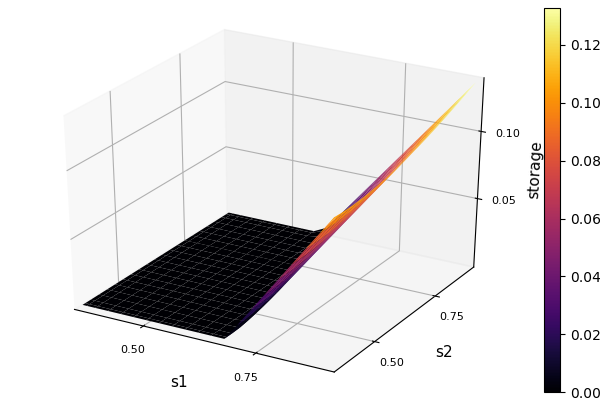

In [88]:
Plots.surface(xgrid, ygrid, z', xlabel="s1", ylabel="s2", zlabel="storage")

In [90]:
newz = Array{Float64, 1}(size(snodes, 1))
for i in 1:size(snodes, 1)
    newz[i] = snodes[i,1]-x_opt[i,1]+snodes[i,2]-x_opt[i,2]
end
newz = newz.^gamma

484-element Array{Float64,1}:
 1.18911 
 1.18103 
 1.16536 
 1.14297 
 1.12183 
 1.10182 
 1.08284 
 1.06481 
 1.04765 
 1.0313  
 1.01569 
 1.00076 
 0.986479
 ⋮       
 0.814856
 0.810232
 0.805686
 0.801218
 0.796824
 0.7925  
 0.788244
 0.78406 
 0.779949
 0.77591 
 0.773252
 0.771933

In [91]:
newz = reshape(newz, n[1]+2, n[2]+2)

22×22 Array{Float64,2}:
 1.18911   1.18103   1.16536   1.14297   …  0.901129  0.894108  0.890658
 1.18103   1.17312   1.15775   1.13579      0.897598  0.890658  0.887248
 1.16536   1.15775   1.14297   1.12183      0.890658  0.883877  0.880544
 1.14297   1.13579   1.12183   1.10182      0.880544  0.873989  0.870767
 1.12183   1.11504   1.10182   1.08284      0.870767  0.864427  0.861308
 1.10182   1.09538   1.08284   1.06481   …  0.861308  0.855171  0.852151
 1.08284   1.07673   1.06481   1.04765      0.852151  0.846207  0.84328 
 1.06481   1.059     1.04765   1.0313       0.84328   0.837518  0.834681
 1.04765   1.04211   1.0313    1.01569      0.834681  0.829092  0.826339
 1.0313    1.02601   1.01569   1.00076      0.826718  0.821922  0.819558
 1.01569   1.01064   1.00076   0.986479  …  0.82191   0.817185  0.814856
 1.00076   0.995933  0.986479  0.97279      0.817183  0.812527  0.810232
 0.986479  0.981852  0.97279   0.959784     0.812537  0.807948  0.805686
 0.978647  0.974155  0.9654


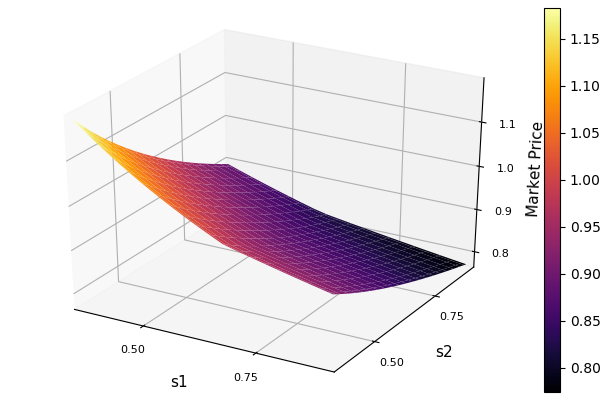

In [92]:
Plots.surface(xgrid, ygrid, newz', xlabel="s1", ylabel="s2", zlabel="Market Price")

In [93]:
gridsize = [30,30]
grid1 = linspace(s_min,s_max,gridsize[1])
grid2 = linspace(s_min,s_max,gridsize[2])
grid = gridmake(grid1, grid2)

900×2 Array{Float64,2}:
 0.353611  0.353611
 0.372693  0.353611
 0.391775  0.353611
 0.410857  0.353611
 0.429939  0.353611
 0.449022  0.353611
 0.468104  0.353611
 0.487186  0.353611
 0.506268  0.353611
 0.52535   0.353611
 0.544432  0.353611
 0.563514  0.353611
 0.582596  0.353611
 ⋮                 
 0.697088  0.906991
 0.716171  0.906991
 0.735253  0.906991
 0.754335  0.906991
 0.773417  0.906991
 0.792499  0.906991
 0.811581  0.906991
 0.830663  0.906991
 0.849745  0.906991
 0.868827  0.906991
 0.887909  0.906991
 0.906991  0.906991

In [94]:
box11_true = ones(size(epsilon, 1))
box22_true = ones(size(epsilon, 1))

function tmp1_true(z::Float64, C::Matrix, x::Matrix, j::Int64, S::Matrix)
    reward1_true = (((S[j,1]-z +S[j,2]-x[j,2]).^gamma) .*(S[j,1]-z) - kappa*z)
    for k in 1:size(epsilon, 1)
        box1_true = funeval( C[:,1], basis, [z+epsilon[k,1], x[j,2]+epsilon[k,2]])
        box11_true[k] = box1_true
    end
    return -(reward1_true + delta*dot(weight, box11_true))
end

function tmp2_true(z::Float64, C::Matrix, x::Matrix, j::Int64, S::Matrix)
    reward2_true = (((S[j,2]-z + S[j,1]-x[j,1]).^gamma) .*(S[j,2]-z) - kappa*z)
    for k in 1:size(epsilon, 1)
        box2_true = funeval( C[:,2], basis, [z+epsilon[k,2], x[j,1]+epsilon[k,1]])
        box22_true[k] = box2_true
    end
    return -(reward2_true + delta*dot(weight, box22_true))
end

tmp2_true (generic function with 1 method)

In [95]:
function update_Bellman_true(MBM::MarketingBoardModel, C::Matrix, x::Matrix, S::Matrix)
    kappa, sigma, delta, gamma, snodes = MBM.kappa, MBM.sigma, MBM.delta, MBM.gamma, MBM.snodes
    V_new_true = Array{Float64,2}(size(S))
    x_opt_true = Array{Float64,2}(size(S))
    for j in 1:size(S, 1)
        fin1(z) = tmp1_true(z,C,x,j,S)
        opt1 = optimize(fin1, 0, 0.2)
        fin2(z) = tmp2_true(z,C,x,j,S)
        opt2 = optimize(fin2, 0, 0.2)

        V_new_true[j,1] = -opt1.minimum
        x_opt_true[j,1] = opt1.minimizer
        V_new_true[j,2] = -opt2.minimum
        x_opt_true[j,2] = opt2.minimizer
    end
    
    return x_opt_true, V_new_true
end

update_Bellman_true (generic function with 1 method)

In [96]:
c_x = Φ.vals[1] \ x_opt
newx = funeval(c_x, basis, grid)

900×2 Array{Float64,2}:
  3.92108e-14  2.88951e-15
 -1.05642e-9   1.46969e-15
  4.32499e-9   1.36675e-15
  1.41229e-9   3.31912e-16
 -2.79551e-8   2.07236e-15
  5.77142e-8   2.72372e-15
  3.74987e-8   2.197e-15  
 -3.88162e-7   5.62525e-15
  6.97576e-7   5.95337e-15
  7.34423e-7   1.94616e-15
 -5.31287e-6   3.94034e-15
  8.21227e-6   5.06339e-15
  1.27562e-5   8.88281e-16
  ⋮                       
  0.049894     8.10228e-15
  0.0576838    7.63827e-15
  0.0654829    7.45036e-15
  0.0732741    8.9514e-15 
  0.0810602    5.43511e-15
  0.0888475    1.31348e-15
  0.0966426    4.21081e-15
  0.104451     5.92255e-15
  0.112275     4.25325e-15
  0.120114     4.0333e-15 
  0.127955     8.33211e-15
  0.135794     1.74229e-15

In [97]:
x_opt_true, v_new_true = update_Bellman_true(MBM, C, newx[:,:,1], grid)

(
[3.09971e-14 5.59001e-15; 3.99245e-15 2.22491e-15; … ; 0.127954 2.51999e-15; 0.135794 3.155e-15],

[9.99218 10.0505; 10.009 10.045; … ; 10.2407 10.4202; 10.2521 10.423])

In [98]:
resid = v_new_true - funeval(C, basis, grid)

900×2 Array{Float64,2}:
 1.50638e-5  1.51754e-5
 1.50566e-5  1.51809e-5
 1.50445e-5  1.51907e-5
 1.5063e-5   1.51762e-5
 1.50493e-5  1.5184e-5 
 1.50542e-5  1.51872e-5
 1.50624e-5  1.51791e-5
 1.50531e-5  1.51593e-5
 1.50557e-5  1.52194e-5
 1.50595e-5  1.52134e-5
 1.50733e-5  1.49533e-5
 1.50311e-5  1.5479e-5 
 1.50163e-5  1.55665e-5
 ⋮                     
 1.50634e-5  1.49678e-5
 1.50616e-5  1.52984e-5
 1.50641e-5  1.51981e-5
 1.50638e-5  1.52112e-5
 1.50644e-5  1.52352e-5
 1.50635e-5  1.52086e-5
 1.50629e-5  1.51746e-5
 1.50652e-5  1.51434e-5
 1.50634e-5  1.51285e-5
 1.5061e-5   1.51536e-5
 1.50645e-5  1.5142e-5 
 1.50638e-5  1.51919e-5

In [99]:
xgrid = zeros(30, 30)
ygrid = zeros(30, 30)
for i in 1:30
    xgrid[i, :] = Array(grid1)'
end
for i in 1:30
    ygrid[:, i] = Array(grid2)
end

In [100]:
z1 = reshape(resid[:,1], (30,30))
z2 = reshape(resid[:,2], (30,30))
z_new = (z1' + z2) / 2

30×30 Array{Float64,2}:
 1.51196e-5  1.51123e-5  1.51003e-5  …  1.5119e-5   1.51191e-5  1.51196e-5
 1.51252e-5  1.51181e-5  1.51064e-5     1.51219e-5  1.51208e-5  1.51197e-5
 1.51347e-5  1.51275e-5  1.51161e-5     1.51182e-5  1.51221e-5  1.51284e-5
 1.51203e-5  1.51145e-5  1.51044e-5     1.51178e-5  1.51189e-5  1.51211e-5
 1.51295e-5  1.51234e-5  1.51134e-5     1.51492e-5  1.51286e-5  1.51001e-5
 1.51291e-5  1.51237e-5  1.51145e-5  …  1.50731e-5  1.51086e-5  1.51604e-5
 1.51219e-5  1.51172e-5  1.51088e-5     1.50923e-5  1.51113e-5  1.514e-5  
 1.51161e-5  1.5111e-5   1.51024e-5     1.53664e-5  1.52026e-5  1.49649e-5
 1.51437e-5  1.51398e-5  1.51326e-5     1.47526e-5  1.49793e-5  1.53163e-5
 1.51392e-5  1.51357e-5  1.5129e-5      1.48034e-5  1.49747e-5  1.52365e-5
 1.5012e-5   1.50053e-5  1.49962e-5  …  1.69091e-5  1.61431e-5  1.48983e-5
 1.52726e-5  1.52729e-5  1.52696e-5     1.31112e-5  1.36493e-5  1.46544e-5
 1.53159e-5  1.53177e-5  1.5316e-5      1.33358e-5  1.36895e-5  1.44543e-5
 


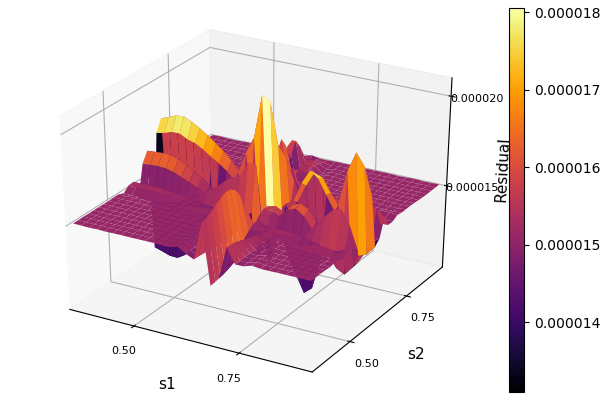

In [101]:
Plots.surface(xgrid, ygrid, z_new, xlabel="s1", ylabel="s2", zlabel="Residual")

In [102]:
# initial_value :: 1st value is the initial wealth level of player1, 2nd one is for the other player
# policy :: policy function defined over the wealth distribution space
# times :: simulation times averaged over
# periods :: simulation period
# p :: the player whose result we want to get

function simulate(MBM::MarketingBoardModel, initial_value::Array{Float64, 1}, basis, C::Array{Float64, 2}, times::Int64, periods::Int64, p::Int64)
    
    srand(12345)
    box = ones(1, 2)
    box1 = ones(1, 2)
    supply_p = zeros(periods+1, times)
    m = qnwlogn(nshocks, mu, cov)[1]
    
    supply_transition = zeros((periods+1, 2))
    supply_transition[1,:] = initial_value
    
    for j in 1:times
        for i in 2:periods+1
            box = funeval(C, basis, [supply_transition[i-1, 1], supply_transition[i-1, 2]])
            epsilon = rand(m, 2)
            supply_transition[i,:] = box + epsilon
        end
        supply_p[:, j] = supply_transition[:, p]
    end
    
    return mean(supply_p, 2)
end

simulate (generic function with 1 method)

In [103]:
# basis coefficient for policy function
c_x = Φ.vals[1] \ x_opt
initial = [0.9, 0.9]
periods = 10
times = 1000

supply_result = simulate(MBM, initial, basis, c_x, times, periods, 1)

11×1 Array{Float64,2}:
 0.9     
 0.649301
 0.540992
 0.524565
 0.5201  
 0.533408
 0.530925
 0.525112
 0.528253
 0.518325
 0.530982


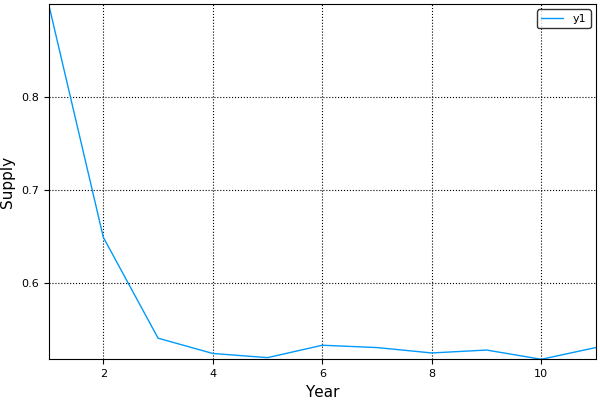

In [106]:
plot(supply_result, xlabel="Year", ylabel="Supply")